In [1]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

from taskSetting import *
from expsInfo import *
from workerInfo import *
from modelSpecificities import *
from funcs_loadData import *
from funcs_analyses import *

/Users/mingyusong/anaconda3/envs/rule-learning/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load data and model fitting results

### Load data

In [2]:
# Read the data from csv; Get the list of participants and their worker IDs
expVersion = 'all'
data, workerIds = load_data(expVersion, getWorkerIds=True)

### Load model fitting results

In [3]:
allModels = [
    'featureRLwDecayNoCost',
    'inferSerialHypoTesting_CountingRandomSwitchEpsilonNoCost_FlexibleHypoAvg',
    'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg',
]

In [4]:
for model in allModels:
    dataThisModel = pd.read_csv('fittingResultsCVTrialLik/' + model + '_' + expVersion + '_allWorkers.csv')
    data[model + '_loglikelihood'] = dataThisModel[model + '_loglikelihood']

### Contribution of SHT and RL

In [5]:
mainModel = 'inferSerialHypoTesting_CountingValueBasedSwitchNoResetDecayEpsilonNoCost_FlexibleHypoAvg'
componentModels = {
    'SHT': 'featureRLwDecayNoCost',
    'RL': 'inferSerialHypoTesting_CountingRandomSwitchEpsilonNoCost_FlexibleHypoAvg',
}

In [6]:
for component in ['SHT', 'RL']:
    data['contribution_' + component + '_loglikdiff'] = data[mainModel + '_loglikelihood'] - data[componentModels[component] + '_loglikelihood']

### Data aggregation

In [7]:
df = pd.DataFrame(index=workerIds)
df['avgreward'] = data.groupby('workerId').mean()['reward']
df['rt'] = data.groupby('workerId').mean()['rt']/1000
for component in ['SHT', 'RL']:
    df['contribution_'+component] = np.exp(data.groupby('workerId')[mainModel + '_loglikelihood'].mean()) - np.exp(data.groupby('workerId')[componentModels[component] + '_loglikelihood'].mean())

## Correlation

### SHT ~ RT, RL ~ reward (Fig 5A,B)

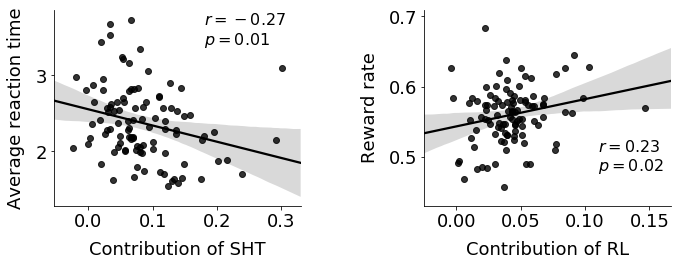

In [8]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1,2,figsize=(10, 4))

label_pos = [[0.18,3.4], [0.11,0.48]]
for component, var, label, pos, ax in zip(['SHT', 'RL'], ['rt', 'avgreward'], ['Average reaction time', 'Reward rate'], label_pos, axes):
    r, p = pearsonr(df['contribution_' + component], df[var])
    sns.regplot('contribution_' + component, var, data=df, fit_reg=p<.05, ax=ax, color='k')
    ax.text(x=pos[0], y=pos[1], s='$r='+str(np.round(r,2))+('$\n$p='+str(np.round(p,2)) if p>.001 else '$\n$p<0.01')+'$', fontsize=16)
    ax.set_xlabel('Contribution of '+ component, labelpad=10)
    ax.set_ylabel(label, labelpad=10)
    sns.despine()
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

### All pairs

1D: r=0.18, p=0.0779
2D: r=0.23, p=0.0214
3D: r=0.14, p=0.1552
1D: r=-0.03, p=0.7524
2D: r=0.27, p=0.0058
3D: r=0.32, p=0.0012


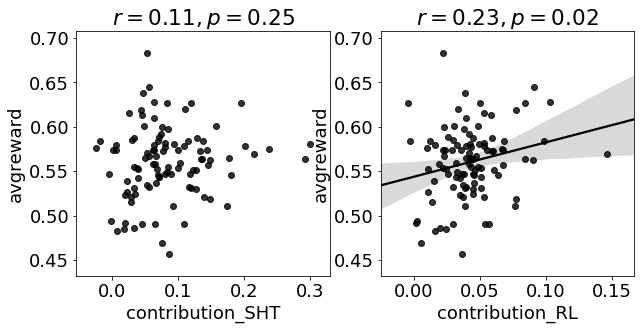

In [9]:
fig, axes = plt.subplots(1,2,figsize=(10, 4.5))
for component, ax in zip(['SHT', 'RL'], axes):
    r, p = pearsonr(df['contribution_' + component], df['avgreward'])
    sns.regplot('contribution_' + component, 'avgreward', data=df, fit_reg=p<.05, ax=ax, color='k')
    ax.set_title('$r='+str(np.round(r,2))+(', p='+str(np.round(p,2)) if p>.001 else '$\n$p<0.001')+'$')
    
    for numRD in np.arange(numDimensions)+1:
        dataTmp = data[data['numRelevantDimensions']==numRD]
        contribution_RL = np.exp(dataTmp.groupby('workerId')[mainModel + '_loglikelihood'].agg(np.nanmean)) - np.exp(dataTmp.groupby('workerId')[componentModels[component] + '_loglikelihood'].agg(np.nanmean))
        reward = dataTmp.groupby('workerId').mean()['reward']
        r, p = pearsonr(contribution_RL, reward)
        print(str(numRD)+'D: r='+str(np.round(r,2))+(', p='+str(np.round(p,4)) if p>.001 else ', p<.001'))

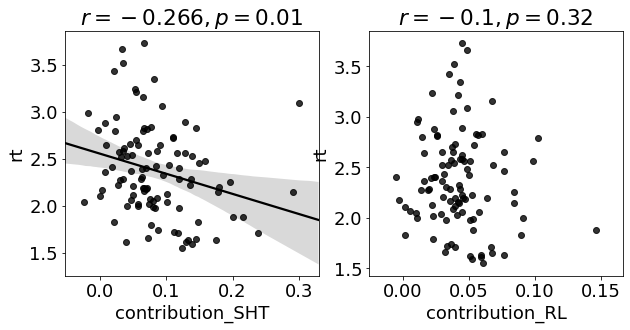

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10, 4.5))
for component, ax in zip(['SHT', 'RL'], axes):
    r, p = pearsonr(df['contribution_' + component], df['rt'])
    sns.regplot('contribution_' + component, 'rt', data=df, fit_reg=p<.05, ax=ax, color='k')
    ax.set_title('$r='+str(np.round(r,3))+(', p='+str(np.round(p,2)) if p>.001 else '$\n$p<0.01')+'$')

## Stats

In [11]:
import statsmodels.api as sm

for var in ['rt', 'avgreward']:
    y = df[var] 
    x1 = df['contribution_SHT'].values
    x2 = df['contribution_RL'].values
    x1 = (x1 - np.mean(x1)) / np.std(x1)
    x2 = (x2 - np.mean(x2)) / np.std(x2)
    x = np.c_[x1, x2, x1 * x2, np.ones((x1.size, 1))]
    mod = sm.OLS(y, x)
    fii = mod.fit()
    print(fii.summary2())
    p_values = fii.summary2().tables[1]['P>|t|']

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.056   
Dependent Variable: rt               AIC:                139.1297
Date:               2022-07-30 13:00 BIC:                149.6296
No. Observations:   102              Log-Likelihood:     -65.565 
Df Model:           3                F-statistic:        2.988   
Df Residuals:       98               Prob (F-statistic): 0.0348  
R-squared:          0.084            Scale:              0.22041 
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
x1        -0.1336     0.0572   -2.3362   0.0215   -0.2472   -0.0201
x2         0.0445     0.0569    0.7819   0.4362   -0.0685    0.1575
x3        -0.0395     0.0385   -1.0265   0.3072   -0.1159    0.0369
const      2.3969     0.0512   46.8560   0.0000    2.2954    2.4984
-------------

In [12]:
from statsmodels.formula.api import ols
df2 = df.copy()
df2['contribution_SHT'] = (df2['contribution_SHT'] - np.mean(df2['contribution_SHT'])) / np.std(df2['contribution_SHT'])
df2['contribution_RL'] = (df2['contribution_RL'] - np.mean(df2['contribution_RL'])) / np.std(df2['contribution_RL'])
for y in ['rt', 'avgreward']:
    formula = f'{y} ~ contribution_SHT + contribution_RL + contribution_SHT * contribution_RL + 1'
    results = ols(formula, df2).fit()
    hypotheses = 'contribution_SHT = contribution_RL'
    t_test = results.t_test(hypotheses)
    print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1782      0.099     -1.808      0.074      -0.374       0.017
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0102      0.008     -1.248      0.215      -0.026       0.006
